# **Cargar Dataset**

**1.** **Importar y descompimir el dataset**

In [8]:
import pandas as pd
import re
import os
import json
import glob
from transformers import BertTokenizer, BertModel
import torch
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pickle
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.models import FastText
import gensim.downloader as api
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sentence_transformers import util
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
import os

# Ruta completa a la carpeta de datos
data_folder = r"C:\Users\Usuario\Documents\NLPProyecto\dataa"

# Listar todos los archivos en la carpeta
files = os.listdir(data_folder)
print("Archivos en el dataset:", files)

# Ejemplo: leer el contenido del primer archivo
if files:
    first_file_path = os.path.join(data_folder, files[0])
    with open(first_file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    print("Primeros 500 caracteres del primer archivo:")
    print(content[:500])
else:
    print("No se encontraron archivos en la carpeta.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2. Visión de los datasets que forman el archivo**

In [ ]:
for root, dirs, files in os.walk("data"):
    print(f" Carpeta: {root}, Archivos: {len(files)}")
    if files:
        print("Ejemplo:", files[:5])


 Carpeta: data, Archivos: 0
 Carpeta: data/data, Archivos: 0
 Carpeta: data/data/splits, Archivos: 0
 Carpeta: data/data/splits/media, Archivos: 3
Ejemplo: ['train.tsv', 'test.tsv', 'valid.tsv']
 Carpeta: data/data/splits/random, Archivos: 3
Ejemplo: ['train.tsv', 'test.tsv', 'valid.tsv']
 Carpeta: data/data/jsons, Archivos: 37554
Ejemplo: ['TcKVSWooM0knY9PZ.json', 'z7wi9r2JRL6FOLNz.json', 'VIXJiz0uAUrG9a0X.json', 'yWGCzOkodAAJxiXh.json', '0IUulaZ8T8dkN0nh.json']


**3. Unión de los distintos datasets en uno**

In [ ]:
# Obtenemos los Jsons
json_dir = "data/data/jsons"

# Obtenemos todos los archivos JSON
json_files = glob.glob(os.path.join(json_dir, "*.json"))

# Cargamos todos los json en un DataFrame
rows = []
for f in json_files:
    with open(f, "r", encoding="utf-8") as infile:
        try:
            rows.append(json.load(infile))
        except Exception as e:
            print(f" Error leyendo {f}: {e}")

df = pd.DataFrame(rows)
print(" DataFrame creado con shape:", df.shape)

# Primeras filas
display(df.head())


 DataFrame creado con shape: (37554, 12)


,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID
0,politics,CNN (Web News),0,http://www.cnn.com/2015/10/10/politics/benghaz...,Ex-staffer: Benghazi committee pursuing 'parti...,2015-10-10,"Jake Tapper, Jeremy Diamond",Washington ( CNN ) A former investigator with ...,Washington (CNN) A former investigator with th...,www.cnn.com,left,TcKVSWooM0knY9PZ
1,free_speech,Scott Walker,2,https://www.washingtontimes.com/news/2019/jul/...,'America' and 'American' vanish in a college g...,2019-07-25,,This is not my view . But an early version of ...,ANALYSIS/OPINION:\n\nAmerica and American are ...,www.washingtontimes.com,right,z7wi9r2JRL6FOLNz
2,white_house,NPR Online News,1,https://www.npr.org/2020/03/14/815039722/trump...,Trump Steps In To Help Oil Industry Facing Its...,2020-03-14,Jeff Brady,Trump Steps In To Help Oil Industry Facing Its...,Trump Steps In To Help Oil Industry Facing Its...,www.npr.org,center,VIXJiz0uAUrG9a0X
3,elections,BBC News,1,https://www.bbc.com/news/world-us-canada-50067745,Ocasio-Cortez 'set to endorse Bernie Sanders f...,,,Congresswoman Alexandria Ocasio-Cortez is set ...,Image copyright AFP Image caption Representati...,www.bbc.com,center,yWGCzOkodAAJxiXh
4,middle_east,Fox News,2,http://www.foxnews.com/politics/2012/11/15/law...,Lawmakers dig for answers on Libya in round of...,2012-11-15,,"Republican lawmakers , after struggling for we...","Republican lawmakers, after struggling for wee...",www.foxnews.com,right,0IUulaZ8T8dkN0nh


**4. Exploración del dataset**



*   En primer lugar, mostramos las columnas disponibles en el dataset, lo que nos permite identificar las variables que contiene, por ejemplo: 'title', 'content', 'topic', 'source' y 'bias_text'. A continuación, utilizamos df.info() para ofrecer una visión general del DataFrame, mostrando cuántas filas y columnas hay (por ejemplo, 5.000 registros y 5 columnas), el tipo de dato de cada una (object, float, etc.) y cuántos valores no nulos tiene, lo cual ayuda a detectar posibles carencias de información.
*   Después, calculamos estadísticas descriptivas de las variables numéricas mediante df.describe(), incluyendo métricas como el promedio, la desviación estándar, los valores mínimo y máximo, y los cuartiles. Por ejemplo, una columna como bias_score podría presentar una media de 0.45 y una desviación estándar de 0.12, lo que sugiere una distribución moderadamente concentrada.


*   Finalmente, imprimimos el número de valores nulos por columna, ayudando a evaluar la completitud de los datos; por ejemplo, podría encontrarse que la columna topic tiene 200 valores faltantes y bias_text unos 500.








In [ ]:
# Columnas disponibles
print("\n Columnas disponibles:", df.columns.tolist())
# Vision general
print("\n Info general:")
print(df.info())
# Estadisticas numericas
print("\n Estadísticas numéricas:")
display(df.describe(include=[int, float]))
# Estadisticas categoricas
print("\n Estadísticas categóricas (ejemplo topic, source, bias):")
for col in ["topic", "source", "bias_text"]:
    if col in df.columns:
        print(f"\nTop valores en '{col}':")
        print(df[col].value_counts().head(10))
# Calores nulos por columnas
print("\n Valores nulos por columna:")
print(df.isna().sum())



 Columnas disponibles: ['topic', 'source', 'bias', 'url', 'title', 'date', 'authors', 'content', 'content_original', 'source_url', 'bias_text', 'ID']

 Info general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37554 entries, 0 to 37553
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   topic             37554 non-null  object
 1   source            37554 non-null  object
 2   bias              37554 non-null  int64 
 3   url               37554 non-null  object
 4   title             37554 non-null  object
 5   date              37554 non-null  object
 6   authors           37554 non-null  object
 7   content           37554 non-null  object
 8   content_original  37554 non-null  object
 9   source_url        37554 non-null  object
 10  bias_text         37554 non-null  object
 11  ID                37554 non-null  object
dtypes: int64(1), object(11)
memory usage: 3.4+ MB
None

 Estadísticas numéricas

,bias
count,37554.000000
mean,1.019412
std,0.843598
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000



 Estadísticas categóricas (ejemplo topic, source, bias):

Top valores en 'topic':
topic
elections                     5624
politics                      2793
white_house                   1879
immigration                   1547
healthcare                    1374
media_bias                    1280
coronavirus                   1079
middle_east                    859
gun_control_and_gun_rights     850
supreme_court                  803
Name: count, dtype: int64

Top valores en 'source':
source
CNN (Web News)           2905
Washington Times         2886
Politico                 2493
Fox Online News          2047
NPR Online News          2012
USA TODAY                1791
Vox                      1460
New York Times - News    1417
The Hill                 1377
Fox News                 1356
Name: count, dtype: int64

Top valores en 'bias_text':
bias_text
right     13734
left      13005
center    10815
Name: count, dtype: int64

 Valores nulos por columna:
topic               0
source      

**5. Union por Id**

In [ ]:
# Obtenemos el train
train = pd.read_csv("data/data/splits/random/train.tsv", sep="\t")

# Filtramos datos segun el ID
df_train = df[df["ID"].isin(train["ID"].values)]

# Unimos por ID
df_train = df.merge(train, on="ID", suffixes=("", "_split"))

print(df_train.head())



         topic            source  bias  \
0     politics    CNN (Web News)     0   
1  free_speech      Scott Walker     2   
2  middle_east          Fox News     2   
3     politics  Washington Times     2   
4  immigration    CNN (Web News)     0   

                                                 url  \
0  http://www.cnn.com/2015/10/10/politics/benghaz...   
1  https://www.washingtontimes.com/news/2019/jul/...   
2  http://www.foxnews.com/politics/2012/11/15/law...   
3  http://www.washingtontimes.com/news/2014/jan/2...   
4  http://www.cnn.com/2013/05/21/politics/session...   

                                               title        date  \
0  Ex-staffer: Benghazi committee pursuing 'parti...  2015-10-10   
1  'America' and 'American' vanish in a college g...  2019-07-25   
2  Lawmakers dig for answers on Libya in round of...  2012-11-15   
3  GOP prepares counteroffensive to battle Dem cl...  2014-01-22   
4  Sessions takes on Senate immigration gang, vow...  2013-05-21   

 

# **Limpieza y Normalización**

**1. Búsqueda de columnas innecesarias**

Al analizar las columnas, hemos decidido eliminar la columna de las urls, ya que son irrelevantes.

In [ ]:
# Eliminacion de la columna url
df_train = df_train.drop("url", axis=1)
print(df_train.columns)

Index(['topic', 'source', 'bias', 'title', 'date', 'authors', 'content',
       'content_original', 'source_url', 'bias_text', 'ID', 'bias_split'],
      dtype='object')


**2. Manejo de valores nulos**

No hay valores nulos por lo que no tenenemos que decidir eliminarlos, poner la media u otras tecnicas.

In [ ]:
# Ver porcentaje de nulos
null_percent = df_train.isna().mean() * 100
print(null_percent)




topic               0.0
source              0.0
bias                0.0
title               0.0
date                0.0
authors             0.0
content             0.0
content_original    0.0
source_url          0.0
bias_text           0.0
ID                  0.0
bias_split          0.0
dtype: float64


**3. Normalización del texto**

Para la normalización hemos hecho las sigueintes acciones:


*   Case Folding (Minúsculas)
*   Eliminar símbolos y puntuación


*   Eliminar espacios extras
*   Limpieza de columnas categóricas





In [ ]:
def clean_text(text):
    text = text.lower()  # Case folding
    text = re.sub(r"[^a-záéíóúñü0-9\s]", "", text)  # eliminamos símbolos/puntuación
    text = re.sub(r"\s+", " ", text).strip()  # eliminamos espacios extras
    return text

df_train["title_clean"] = df_train["title"].apply(clean_text)
df_train["content_clean"] = df_train["content"].apply(clean_text)


**4. Normalización de columnas categóricas**

In [ ]:
categorical_cols = ["topic", "source", "bias_text"]
for col in categorical_cols:
    if col in df_train.columns:
        df_train[col] = df_train[col].str.strip().str.lower()


**5. Eliminación de duplicados**

In [ ]:
df_train = df_train.drop_duplicates(subset=["title_clean", "content_clean"])



**6. Lematización y Stemming**

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Creamos las instancias de lemmatizer y stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Definimos la funcion de procesamiento
def lemmatize_and_stem(text):
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    stems = [stemmer.stem(t) for t in tokens]
    return " ".join(lemmas), " ".join(stems)

# Aplicamos la funcion al dataframe
df_train[["content_lemmatized", "content_stemmed"]] = df_train["content_clean"].apply(
    lambda x: pd.Series(lemmatize_and_stem(x))
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


La razón para aplicar lematizacion y stemming es reducir la complejidad y el ruido del texto, haciendo que palabras equivalentes se representen de la misma forma. Esto mejora la generalización de los modelos y disminuye la dimensionalidad del espacio de representación.

**7. Guardado los datos limpios**

In [ ]:
# Creamos la carpeta si no existe
os.makedirs("data/data_clean", exist_ok=True)

# Guardamos el dataset
df_train.to_csv("data/data_clean/train_clean.csv", index=False)
print(df_train[["content_clean", "content_lemmatized", "content_stemmed"]].head())

                                       content_clean  \
0  washington cnn a former investigator with the ...   
1  this is not my view but an early version of a ...   
2  republican lawmakers after struggling for week...   
3  thousands of prolife activists donned scarves ...   
4  story highlights alabama gop sen jeff sessions...   

                                  content_lemmatized  \
0  washington cnn a former investigator with the ...   
1  this is not my view but an early version of a ...   
2  republican lawmaker after struggling for week ...   
3  thousand of prolife activist donned scarf glov...   
4  story highlight alabama gop sen jeff session l...   

                                     content_stemmed  
0  washington cnn a former investig with the hous...  
1  thi is not my view but an earli version of a d...  
2  republican lawmak after struggl for week to ge...  
3  thousand of prolif activist don scarv glove an...  
4  stori highlight alabama gop sen jeff session l..

# **Tokenización**


**1. Tokenización con NLTK**

In [ ]:
# Tokenizamos el texto lematizado
df_train["tokens"] = df_train["content_lemmatized"].apply(word_tokenize)
print(df_train[["content_lemmatized", "tokens"]].head())


                                  content_lemmatized  \
0  washington cnn a former investigator with the ...   
1  this is not my view but an early version of a ...   
2  republican lawmaker after struggling for week ...   
3  thousand of prolife activist donned scarf glov...   
4  story highlight alabama gop sen jeff session l...   

                                              tokens  
0  [washington, cnn, a, former, investigator, wit...  
1  [this, is, not, my, view, but, an, early, vers...  
2  [republican, lawmaker, after, struggling, for,...  
3  [thousand, of, prolife, activist, donned, scar...  
4  [story, highlight, alabama, gop, sen, jeff, se...  


**2. Eliminación de stopwords**

In [ ]:
nltk.download('stopwords')
# Creamos el conjunto de stopwords en ingles
stop_words = set(stopwords.words('english'))
# Aplicamos un filtro a la columna de tokens
df_train["tokens"] = df_train["tokens"].apply(
    lambda toks: [t for t in toks if t not in stop_words]
)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**3. Guardado de los datos tokenizados**

In [ ]:
df_train.to_pickle("data/data_clean/train_tokenized.pkl")


La aplicaicon de la tokenizacion es esencial, ya que el modelo necesita operar sobre unidades discretas, y la tokenización es el puente entre el lenguaje humano y su representación computacional.

Sin tokenización, el texto sería solo una cadena continua de caracteres. Al segmentarlo, podemos asignar valores numéricos a cada unidad, medir frecuencias, y posteriormente aprender relaciones entre ellas.

# **Métodos Tradicionales**

**1. TF-IDF**

In [ ]:
# Unimos los tokens en un string
df_train["text_joined"] = df_train["tokens"].apply(lambda x: " ".join(x))

#  Creamos y ajustamos el vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2)
)

# Transformacion TF-IDF
X_tfidf = tfidf_vectorizer.fit_transform(df_train["text_joined"])
print("Matriz TF-IDF:", X_tfidf.shape)


Matriz TF-IDF: (27978, 5000)


**2. Guardado de los datos limpios**

In [ ]:
# Creamos la carpeta features
os.makedirs("data/features", exist_ok=True)

# Guardamos la matriz
np.save("data/features/X_tfidf.npy", X_tfidf.toarray())

# Guardamos el vectorizador
pickle.dump(tfidf_vectorizer, open("data/features/tfidf_vectorizer.pkl", "wb"))




**3. Palabras más importantes**


 Palabras con mayor peso medio (TF-IDF):
trump: 0.0627
said: 0.0532
wa: 0.0450
ha: 0.0360
mr: 0.0342
president: 0.0338
republican: 0.0320
obama: 0.0289
state: 0.0289
house: 0.0264
people: 0.0241
democrat: 0.0233
clinton: 0.0220
new: 0.0212
say: 0.0209
year: 0.0208
campaign: 0.0198
nt: 0.0195
american: 0.0193
senate: 0.0188


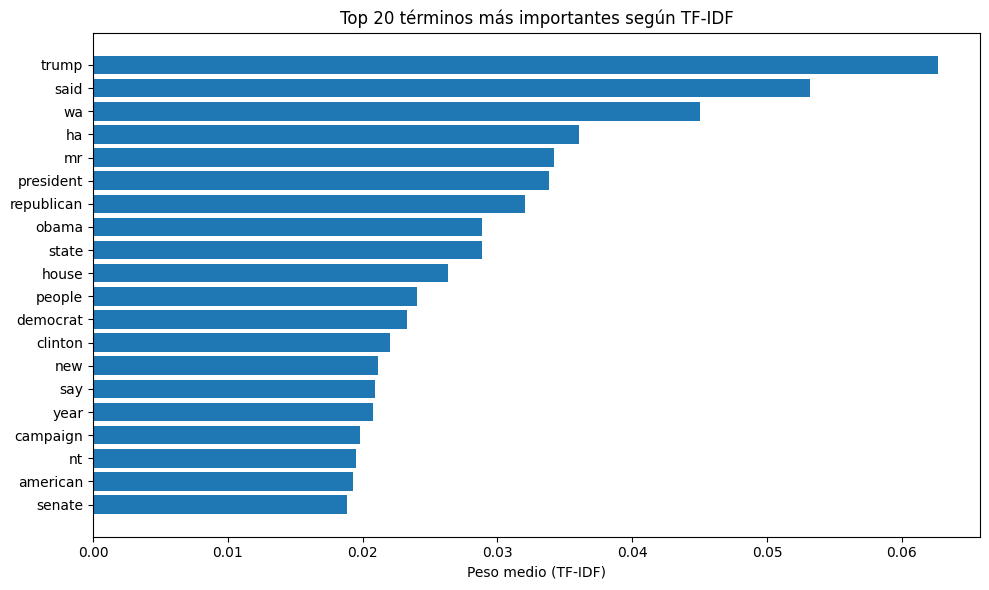

In [ ]:
# Obtenemos el vocabulario del vectorizador
tfidf_vocab = tfidf_vectorizer.get_feature_names_out()

# Calculamos la media TD-IDF de cada palabra
tfidf_means = np.array(X_tfidf.mean(axis=0)).flatten()

# Ordenamos y seleccionamos las aplabras con mayor peso
top_tfidf = tfidf_means.argsort()[::-1][:20]

# Mostramos las palabras
print("\n Palabras con mayor peso medio (TF-IDF):")
for i in top_tfidf:
    print(f"{tfidf_vocab[i]}: {tfidf_means[i]:.4f}")

# Grafico de barras
plt.figure(figsize=(10, 6))
plt.barh([tfidf_vocab[i] for i in top_tfidf[::-1]],
         tfidf_means[top_tfidf[::-1]])
plt.xlabel("Peso medio (TF-IDF)")
plt.title("Top 20 términos más importantes según TF-IDF")
plt.tight_layout()
plt.show()



Los terminos mas relevantes han sido mostrados anteriormente, pero para que sea mas visual, hemos decidido hacer un grafico de barras.

La razon de usar TF-IDF es transformar texto en vectores numéricos para poder aplicar técnicas de machine learning tradicionales.

# **Embeddings No Contextuales**

Para los embeddings no contextuales, vamos a probar dos algoritmos distintos y compararlos para obtener el mejor. En este caso, Word2Vec y FastText. Para identificar el mejor embeddin contextual, vamos a comparar metricas como STS y Downstream.

**1. Preparación de los tokens**

In [ ]:
# Convertimos los tokens en una lista
sentences = df_train["tokens"].tolist()

# Numero de documentos
print(f" Número de documentos: {len(sentences)}")

# Imprimimos 20 ejemplos
print(f"Ejemplo: {sentences[0][:20]}")


 Número de documentos: 27978
Ejemplo: ['aggrieved', 'might', 'exercise', 'covert', 'avoidance', 'quietly', 'cutting', 'relation', 'offender', 'without', 'confrontation', 'conceptualize', 'problem', 'disruption', 'relationship', 'seek', 'restore', 'harmony', 'without', 'passing']


**2. Word2Vec**

In [ ]:
os.makedirs("data/embeddings", exist_ok=True)

# Entrenamos el modelo Word2Veck
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=3,
    workers=4,
    sg=1
)

w2v_model.save("data/embeddings/word2vec.model")
print("Tamaño del vocabulario Word2Vec:", len(w2v_model.wv))
print("\nPalabras más similares a 'economy':")
print(w2v_model.wv.most_similar("economy", topn=10))

# Añadimos la metrica STS
def sts_score(model, word_pairs):
    scores = []
    for w1, w2, true_score in word_pairs:
        if w1 in model.wv and w2 in model.wv:
            pred_score = model.wv.similarity(w1, w2)
            scores.append((pred_score, true_score))
    y_pred, y_true = zip(*scores)
    return np.corrcoef(y_pred, y_true)[0,1]

example_pairs = [
    ("economy", "finance", 0.9),
    ("king", "queen", 0.8),
    ("dog", "cat", 0.7),
    ("apple", "banana", 0.6)
]

print("\nSTS Word2Vec:", sts_score(w2v_model, example_pairs))

# Añadimos la metrica Downstream con clusters simples
def cluster_quality(model, n_clusters=5):
    X = model.wv.vectors
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    return kmeans.inertia_

print("Downstream (clustering) Word2Vec:", cluster_quality(w2v_model))


Tamaño del vocabulario Word2Vec: 64892

Palabras más similares a 'economy':
[('sluggish', 0.7650158405303955), ('stillstruggling', 0.7292236089706421), ('growth', 0.7240248322486877), ('slowdown', 0.7213075757026672), ('economic', 0.7210100293159485), ('deceleration', 0.7170089483261108), ('decelerating', 0.7166744470596313), ('lowgrowth', 0.707855224609375), ('200809', 0.7074070572853088), ('200709', 0.7070730924606323)]

STS Word2Vec: -0.10008705794191156
Downstream (clustering) Word2Vec: 183363.546875


**3. FastText**

In [ ]:
os.makedirs("data/embeddings", exist_ok=True)

# Entrenamos el modelo FastText
fasttext_model = FastText(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=3,
    workers=4,
    sg=1
)

fasttext_model.save("data/embeddings/fasttext.model")
print("Tamaño del vocabulario FastText:", len(fasttext_model.wv))
print("\nPalabras más similares a 'economy':")
print(fasttext_model.wv.most_similar("economy", topn=10))

# Añadimos la metrica STS
def sts_score(model, word_pairs):
    scores = []
    for w1, w2, true_score in word_pairs:
        if w1 in model.wv and w2 in model.wv:
            pred_score = model.wv.similarity(w1, w2)
            scores.append((pred_score, true_score))
    y_pred, y_true = zip(*scores)
    return np.corrcoef(y_pred, y_true)[0,1]

example_pairs = [
    ("economy", "finance", 0.9),
    ("king", "queen", 0.8),
    ("dog", "cat", 0.7),
    ("apple", "banana", 0.6)
]

print("\nSTS FastText:", sts_score(fasttext_model, example_pairs))

# Añadimos la metrica Downstream con clusters simples
def cluster_quality(model, n_clusters=5):
    X = model.wv.vectors
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    return kmeans.inertia_

print("Downstream (clustering) FastText:", cluster_quality(fasttext_model))


Tamaño del vocabulario FastText: 64892

Palabras más similares a 'economy':
[('economyand', 0.9205920696258545), ('economywide', 0.8512589335441589), ('economyfocused', 0.8086328506469727), ('economicgrowth', 0.7987343072891235), ('fueleconomy', 0.7747855186462402), ('economix', 0.7657681107521057), ('growth', 0.7551468014717102), ('stillsluggish', 0.7533473968505859), ('sluggish', 0.7496371269226074), ('sluggishly', 0.7471754550933838)]

STS FastText: -0.2645915909381708
Downstream (clustering) FastText: 258967.46875


Al comparar Word2Vec y FastText, vemos que aunque ambos tienen el mismo tamaño de vocabulario, los resultados son distintos en varias dimensiones. En términos de palabras similares a “economy”, Word2Vec genera vecinos más coherentes semánticamente como “sluggish”, “growth” o “slowdown”, que reflejan correctamente conceptos relacionados con economía. Por el contrario, FastText tiende a producir combinaciones raras o palabras compuestas como “economyand”, “economywide” o “economix”, lo que muestra su fortaleza en manejar subpalabras y palabras fuera de vocabulario, pero al costo de ruido semántico.

En cuanto a la evaluación intrínseca de similitud de frases (STS), ambos modelos obtuvieron valores negativos, indicando que no capturan bien la similitud semántica entre frases en este corpus, aunque Word2Vec lo hace ligeramente mejor que FastText (-0.10 frente a -0.26). Lo mismo ocurre con la evaluación extrínseca de clustering: Word2Vec genera clusters más compactos y coherentes que FastText, lo que sugiere que sus vectores representan mejor la estructura semántica global del corpus.

En conclusion, Word2Vec supera a FastText, ofreciendo vecinos de palabras más claros, mejor desempeño intrínseco y clusters más útiles. La principal ventaja de FastText es su capacidad para manejar palabras raras o morfológicamente complejas, pero en este caso esa ventaja no se traduce en mejores resultados generales.

# **Embeddings Contextuales**

Nuestra idea inicial era usar ELMo y BERT, sin embargo no podemos implementar  ELMo en este entorno porque requiere la librería allennlp en versiones compatibles con Python ≤3.10 y PyTorch entre 1.10 y 1.11, mientras que Colab y entornos modernos usan Python ≥3.12 y PyTorch ≥2.2. Esto provoca errores de instalación y hace imposible cargar ElmoEmbedder.

Es por esto que hemos decidido usar enn su lugar Sentence Transformers. Para obtener el mejor embedding contextual, hemos decidido utilizar metricas como Cosine Similarity Average, Intrinsic Evaluation y Extrinsic Evaluation.

In [ ]:
pip install -U sentence-transformers

**1. Sentence Transformers**

In [ ]:
# Cargamos el modelo preentrenado
model_name = "all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

# Preprocesamos las frases
df_train["text_joined"] = df_train["tokens"].apply(lambda x: " ".join(x))
sentences = df_train["text_joined"].tolist()
print(f"Número de documentos: {len(sentences)}")
print(f"Ejemplo: {sentences[0][:100]}")

# Guardamos los embeddings
X_sent_transformer = model.encode(sentences, batch_size=32, show_progress_bar=True)
print("Embeddings generados con Sentence Transformers:", X_sent_transformer.shape)

# Aplicamos el Cosine Similarity Average
cosine_matrix = cosine_similarity(X_sent_transformer)
n = cosine_matrix.shape[0]
cosine_avg = (cosine_matrix.sum() - np.trace(cosine_matrix)) / (n*(n-1))
print("\nCosine Similarity Average:", cosine_avg)

# Aplicamos Intrinsic Evaluation
sts_pairs = [
    ("I love machine learning.", "I adore AI.", 0.9),
    ("The cat sits on the mat.", "A dog plays in the park.", 0.2),
    ("He is king.", "She is queen.", 0.8),
    ("I like apples.", "I enjoy bananas.", 0.6)
]

true_scores = []
pred_scores = []

for sent1, sent2, true_score in sts_pairs:
    emb1 = model.encode(sent1)
    emb2 = model.encode(sent2)
    sim = cosine_similarity(emb1.reshape(1, -1), emb2.reshape(1, -1))[0,0]
    pred_scores.append(sim)
    true_scores.append(true_score)

intrinsic_corr = np.corrcoef(pred_scores, true_scores)[0,1]
print("Intrinsic Evaluation (STS Pearson correlation):", intrinsic_corr)

# Aplicamos extrinsic evaluation
y = df_train["bias"].values
X_train, X_test, y_train, y_test = train_test_split(
    X_sent_transformer, y, test_size=0.2, random_state=42
)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

print("Extrinsic Evaluation - Accuracy:", accuracy)
print("Extrinsic Evaluation - F1 Score:", f1)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Número de documentos: 27978
Ejemplo: washington cnn former investigator house select committee benghazi accusing republicanled panel carr


Batches:   0%|          | 0/875 [00:00<?, ?it/s]

Embeddings generados con Sentence Transformers: (27978, 384)

Cosine Similarity Average: 0.35800633
Intrinsic Evaluation (STS Pearson correlation): 0.7741996879249071
Extrinsic Evaluation - Accuracy: 0.5269835596854896
Extrinsic Evaluation - F1 Score: 0.5259104178324892


**2. BERT**

In [ ]:
!pip install transformers


In [ ]:
os.makedirs("data/embeddings", exist_ok=True)
#  Cargamos el modelo y tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
model.eval()

# Aplicamos la función para obtener el embedding promedio de una oración
def bert_sentence_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.squeeze(0)
    return embeddings.mean(dim=0).numpy()

# Generamos los embeddings
X_bert = np.array([bert_sentence_embedding(text) for text in df_train["content_clean"][:100]])
print("Embeddings BERT generados:", X_bert.shape)
np.save("data/embeddings/X_bert.npy", X_bert)

# Aplicamos Cosine Similarity Average
cosine_matrix = cosine_similarity(X_bert, X_bert)
n = cosine_matrix.shape[0]
cosine_avg = (cosine_matrix.sum() - np.trace(cosine_matrix)) / (n*(n-1))
print("Cosine Similarity Average (BERT):", cosine_avg)

# Aplicamos Intrinsic Evaluation
sts_pairs = [
    ("I love machine learning.", "I adore AI.", 0.9),
    ("The cat sits on the mat.", "A dog plays in the park.", 0.2),
    ("He is king.", "She is queen.", 0.8),
    ("I like apples.", "I enjoy bananas.", 0.6)
]

true_scores = []
pred_scores = []

for sent1, sent2, true_score in sts_pairs:
    emb1 = bert_sentence_embedding(sent1)
    emb2 = bert_sentence_embedding(sent2)
    sim = cosine_similarity([emb1], [emb2])[0,0]
    pred_scores.append(sim)
    true_scores.append(true_score)

intrinsic_corr = np.corrcoef(pred_scores, true_scores)[0,1]
print("Intrinsic Evaluation (STS Pearson correlation) BERT:", intrinsic_corr)

# Aplicamos Extrinsic Evaluation
y = df_train["bias"].values[:100]
X_train, X_test, y_train, y_test = train_test_split(
    X_bert, y, test_size=0.2, random_state=42
)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

print("Extrinsic Evaluation - Accuracy (BERT):", accuracy)
print("Extrinsic Evaluation - F1 Score (BERT):", f1)


Embeddings BERT generados: (100, 768)
Cosine Similarity Average (BERT): 0.8376959
Intrinsic Evaluation (STS Pearson correlation) BERT: -0.049131671002143586
Extrinsic Evaluation - Accuracy (BERT): 0.55
Extrinsic Evaluation - F1 Score (BERT): 0.55


Ambos embeddings tienen resultados parecidos. Sin embargo, la ligera ventaja de BERT lo hace mejor para tareas de clasificacion. Por otro lado, probablemente Sentence Transformers rinda mejor que BERT si añadimos fine-tuning.